# Basics Tutorial for Snorkel MeTaL

The purpose of this tutorial is to introduce the basic pipeline, classes, and debugging/analysis tools in Snorkel MeTaL. In this notebook, we'll investigate a single-task problem with synthetic data, with an emphasis on the basic design concepts of MeTaL. Check out the `tutorials/` directory to see how this basic pipeline extends to the full _multi-task_ setting, and other topics.

This tutorial consists of four steps, following the basic [data programming](https://arxiv.org/abs/1605.07723) pipeline as in [Snorkel](snorkel.stanford.edu):
1. **Load Data:** In the _weakly supervised_ setting, we only have access to unlabeled data points `X`, matrix of noisy labels `L`, and dev/test labels `Y`*
2. **Train Label Model:** The purpose of the `LabelModel` is to estimate the unknown accuracies of the labeling functions, _without access to `Y`_, and then use this to denoise and combine them into a set of _probabilistic training labels_.
3. **Train End Model:** We can then use these training labels to supervise a discriminative classifier!
4. **Evaluate:** We evaluate this model on a held-out test set

Let's get started!

### Setup

We first need to make sure that the `metal/` directory is on our Python path. If the following cell runs without an error, you're all set. If not, make sure that you've installed `snorkel-metal` with pip or conda (or that you've added the repo to your path if you're running from source; for example, running `source add_to_path.sh` from the repository root).

In [1]:
import sys
sys.path.append('../../metal')
import metal

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Step 1: Load Data

The first step in a Snorkel MeTaL application is preparing your data.

### Concept 1: Required Data Types

In particular, MeTaL makes use of the following types of data (n = # examples, m = # labeling functions):
* X: an \[n\]-dim iterable of end model inputs (e.g., feature vectors or encoded sentences for an RNN)
* Y: an \[n\]-dim numpy.ndarray of target labels ($Y \in \{1,...,k\}^n$)
* L: an \[n,m\] scipy.sparse matrix of noisy labels ($L \in \{0,...,k\}^{n \times m}$, with label 0 reserved for abstentions

And optionally (for use with some debugging/analysis tools):
* D: an \[n\]-dim iterable of human-readable examples (e.g., sentences)

In this tutorial, we use pre-generated synthetic data, where each example is a bag of words drawn from a different gaussian distribution for each class from a 1000-word vocabulary, and our features are simply the 1000-dimensional vector of counts for each word. For some excellent resources on how to write labeling functions, see the Snorkel tutorials at https://github.com/HazyResearch/snorkel/tree/master/tutorials.

In [3]:
import pickle

with open("data/basics_tutorial.pkl", 'rb') as f:
    X, Y, L, D = pickle.load(f)

If you need to divide your data into splits, you can do so with the provided utility function. We split our data 80/10/10 into train/dev/test, stratifying by the labels in `Y` to ensure a similar class balance in each split.

In [4]:
from metal.utils import split_data

Xs, Ys, Ls, Ds = split_data(X, Y, L, D, splits=[0.8, 0.1, 0.1], stratify_by=Y, seed=123)

### Investigate Label Matrices

MeTaL comes with a number of analysis tools for investigating your label matrix. 
For example, you can view summary statistics for each labeling function.
If you have a dev set with gold labels, you can view the empirical accuracy of your functions, in addition to the core summary statistics such as coverage, overlaps, and conflicts.

In [5]:
from metal.analysis import lf_summary

lf_summary(Ls[1])

,Polarity,Coverage,Overlaps,Conflicts
0,"[1, 2]",0.700,0.700,0.655
1,"[1, 2]",0.735,0.735,0.700
2,"[1, 2]",0.744,0.744,0.701
3,"[1, 2]",0.748,0.748,0.706
4,"[1, 2]",0.719,0.719,0.675
5,"[1, 2]",0.746,0.746,0.696
6,"[1, 2]",0.762,0.762,0.728
7,"[1, 2]",0.796,0.796,0.744
8,"[1, 2]",0.811,0.811,0.756
9,"[1, 2]",0.784,0.784,0.735


If you're interested in more graphical investigative tools, you can take a look at the Visualization tutorial.  
Once you're satisfied with your label matrices, it's time to aggregate the labels using the label model and train an end model with the resulting probabilistic labels.

## Step 2: Train Label Model

### Concept: Config dicts

All Snorkel MeTaL models are driven by configuration dictionaries, or config dicts; that is, all settings for running the given model are stored in a single dictionary, `self.config`. 

When a model is initialized or the train_model() method is called, any extra keyword arguments passed by the user will be used to update the config dict. Then, throughout the class's methods, whenever a setting needs to be looked up, it is pulled from this dictionary, rather than required as a keyword. This has a number of benefits:

1. Default values are stored in only one place, the default config dict, rather than in multiple method signatures.
1. Code maintenance is simplified, since fewer keyword arguments need to be passed up and down the call stack.
2. Logging is simplified, since the complete settings for a given model can be logged by simply writing the config dict (a python dictionary) to file.

### Label Model

When constructing a LabelModel, the only required argument is `k`, the cardinality of the task. For example, k=2 means a binary classification task.

In [6]:
from metal.label_model import LabelModel
label_model = LabelModel(k=2, seed=123)

The only required argument to `LabelModel.train_model()` is a label matrix. All other keyword arguments are optional. 

For example, if you know the class_balance of our data, you can pass that in as a list or array; alternatively, you may pass in the target labels of your dev set (`Y_dev`) and have the class balance estimated from that. If neither of these is provided, the classes are assumed to be uniformly distributed.

Any other keyword arguments (e.g., the number of epochs (`n_epochs`), print frequency (`print_every`), learning rate (`lr`), L2 regularization (`l2`), optimizer type (`optimizer`), etc.) will be used to update the config dict.

In [7]:
%%time
label_model.train_model(Ls[0], Y_dev=Ys[1], n_epochs=500, print_every=25)

Computing O...
Estimating \mu...
[E:0]	Train Loss: 6.028
[E:25]	Train Loss: 0.438
[E:50]	Train Loss: 0.029
[E:75]	Train Loss: 0.004
[E:100]	Train Loss: 0.003
[E:125]	Train Loss: 0.003
[E:150]	Train Loss: 0.002
[E:175]	Train Loss: 0.002
[E:200]	Train Loss: 0.002
[E:225]	Train Loss: 0.002
[E:250]	Train Loss: 0.002
[E:275]	Train Loss: 0.002
[E:300]	Train Loss: 0.002
[E:325]	Train Loss: 0.002
[E:350]	Train Loss: 0.002
[E:375]	Train Loss: 0.002
[E:400]	Train Loss: 0.002
[E:425]	Train Loss: 0.002
[E:450]	Train Loss: 0.002
[E:475]	Train Loss: 0.002
[E:499]	Train Loss: 0.002
Finished Training
CPU times: user 1 s, sys: 116 ms, total: 1.12 s
Wall time: 1.05 s


You can test the quality of our label model on our dev set as a sanity check, but we'll see if we can do better in Step 3 by using the predictions of the label model to train a discriminative model over a larger feature set than just the outputs of these ten labeling functions.

In [8]:
score = label_model.score((Ls[1], Ys[1]))

Accuracy: 0.879
        y=1    y=2   
 l=1    181    56    
 l=2    65     698   


By default, the score method reports accuracy, but you can also give it a list of metrics to report. Depending on your application, F1 score may be a more natural metric to use, especially if you have large class imbalance. Our synthetic data, for example, has an approximate 25/75 split.

In [9]:
scores = label_model.score((Ls[1], Ys[1]), metric=['precision', 'recall', 'f1'])

Precision: 0.764
Recall: 0.736
F1: 0.749
        y=1    y=2   
 l=1    181    56    
 l=2    65     698   


We can see that our trained `LabelModel` outperforms the baseline of taking the majority vote label by approximately 4 points in accuracy and 3 F1 points on the dev set.

In [10]:
from metal.label_model.baselines import MajorityLabelVoter

mv = MajorityLabelVoter(seed=123)
scores = mv.score((Ls[1], Ys[1]), metric=['precision', 'recall', 'f1'])

Precision: 0.623
Recall: 0.841
F1: 0.716
        y=1    y=2   
 l=1    207    125   
 l=2    39     629   


### Concept: Classifier Base Class

Both the `LabelModel` and `EndModel` in MeTaL are children of the parent `Classifier` class. The `Classifier` class defines three important methods related to making predictions:
* `predict_proba()`: Returns an [n, k+1] numpy array of probabilistic labels (k+1 because of the option to abstain)
* `predict()`: Returns an [n]-dim numpy array of hard (integer) labels in {0,...,k+1}
* `score()`: Returns the score (default: accuracy) of the predictions with respect to target labels

Following the data programming paradigm, we will use our label model's soft predictions as training labels for a discriminative end model. Because we want probabilistic labels, we use the `predict_proba()` method here. The predictions are in the form of an [n,k] np.ndarray of floats summing to 1.0 in each row, where `Y_ps[i,j]` is the predicted probability of the $i$th data point having true label $j$.

In [11]:
Ls[0].todense()[1]

matrix([[0, 2, 2, 2, 0, 0, 2, 1, 2, 2]], dtype=int64)

In [12]:
# Y_train_ps stands for "Y[labels]_train[split]_p[redicted]s[oft]"
Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_ps

array([[0.33879494, 0.66120506],
       [0.01750566, 0.98249434],
       [0.02757502, 0.97242498],
       ...,
       [0.74142166, 0.25857834],
       [0.98866598, 0.01133402],
       [0.38616893, 0.61383107]])

### Analysis tools

At this point, we may want to analyze our LabelModel's predictions so that we better understand what our model is learning.

We can take a look at the confusion matrix to get a sense for class size, error rates, and commonly confused classes.

In [13]:
from metal.analysis import confusion_matrix

Y_dev_p = label_model.predict(Ls[1])

cm = confusion_matrix(Ys[1], Y_dev_p)

        y=1    y=2   
 l=1    181    65    
 l=2    56     698   


If matplotlib is installed, we can also use some of the visualization tools provided in the `contrib/` directory to plot the label distributions.  
First, we observe that our problem has a severe class imbalance, which our classifier captures in a general sense.  
Second, we can look at how confident our model is in its predictions for class 1 and see that most have probabilities very close to 0.

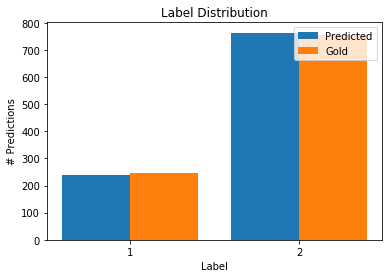

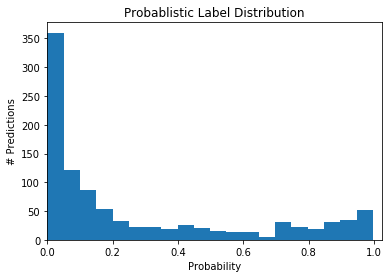

In [14]:
try:
    from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
    )

    plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

    Y_dev_ps = label_model.predict_proba(Ls[1])
    plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")

except ModuleNotFoundError:
    print("The tools in contrib/visualization/ require matplotlib. Try `conda/pip install matplotlib`.")

## Step 3: Train End Model

We will now construct and train our `EndModel` on the predictions from the LabelModel. Here we describe the construction of a single-task end model. For details on the construction of multi-task end models, refer to the multi-task tutorial.

The `EndModel` consists of three components: an *input layer*, zero or more *middle layers*, and a *head layer*, with each layer consisting of a torch.nn.Module followed by various optional additional operators (e.g., a ReLU nonlinearity, batch normalization, and/or dropout). 

* **Input layer**:
The input module is an IdentityModule by default, which simply accepts arbitrary-length feature vectors from X as torch.Tensors and passes them on to the next module in the network. If, however, you would like provide your data in some other format, you may pass in a custom nn.Module which maps your input type to torch.Tensors (for example, if your data points are images, you may pass in a ResNet as your input module).

* **Middle layers**
The middle layers are layers between the input layer and head layer. Middle modules are nn.Linear by default.

* **Head layer**:
The head layer is the final layer, consisting of an nn.Linear module (plus a softmax operation when making predictions).
 
When initiated, the EndModel requires a list of output dimensions. 
The first element is the output dimension of the input module (which is equal to the dimensionality of your feature vectors if using the default Identitymodule).
The last element is the cardinality of the classifier.
The elements in the middle define the number and dimensionality of any middle layers.

In [15]:
from metal.contrib.slicing.online_dp import SliceDPModel, LinearModule
from metal.modules import LSTMModule
import numpy as np

m = Ls[0].shape[1]
accs = [0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.8, 0.9, 0.1]

# compute accs
c_probs = label_model.get_conditional_probs()
k = 2
accs = np.zeros((m, k))

accs = np.zeros(m)
for i in range(m):
    idx_start = i*(k+1)
    # P(lambda_i=1 | Y=1) + P(lambda_i=2 | Y=2)
    accs[i] = c_probs[idx_start+1][0] + c_probs[idx_start+2][1]

# fix our of range examples
accs = np.minimum(accs, 0.999)

In [16]:
r_dim = 2
rw = True
slice_model = SliceDPModel(LinearModule(1000, r_dim), accs, r_dim, rw, seed=123, use_cuda=True)

/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Slice Heads:
Input Network: Sequential(
  (0): Sequential(
    (0): LinearModule(
      (input_layer): Linear(in_features=1000, out_features=2, bias=False)
    )
    (1): ReLU()
  )
)
L_head: Linear(in_features=2, out_features=10, bias=False)
Y_head: Linear(in_features=4, out_features=2, bias=False)


In [17]:
L_train = Ls[0]
L_train[L_train==2] = -1
slice_model.train_model((Xs[0], Ls[0]), dev_data=(Xs[1], Ys[1]), l2=0.1, batch_size=256, 
                n_epochs=5, print_every=1, validation_metric='f1')

Using GPU...


/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
../../metal/metal/contrib/slicing/online_dp.py:166: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  A = F.softmax(self.forward_L(x)).unsqueeze(1)



Saving model at iteration 0 with best score 0.935
[E:0]	Train Loss: 0.026	Dev f1: 0.935



Saving model at iteration 1 with best score 0.992
[E:1]	Train Loss: 0.023	Dev f1: 0.992



Saving model at iteration 2 with best score 0.994
[E:2]	Train Loss: 0.023	Dev f1: 0.994



Saving model at iteration 3 with best score 0.996
[E:3]	Train Loss: 0.022	Dev f1: 0.996



[E:4]	Train Loss: 0.022	Dev f1: 0.992
Restoring best model from iteration 3 with score 0.996
Finished Training
F1: 0.996
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   


In [18]:
from metal.end_model import EndModel
import torch
use_cuda = torch.cuda.is_available()
end_model = EndModel([1000,10,2], seed=123, use_cuda=use_cuda)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)



Once initiated, the network structure is printed so you can confirm that it captured the architecture you want.

To train the model, we pass in our unlabeled training data, our predicted soft labels from the label aggregator, a dev set X and Y if we want to checkpoint the best model seen so far as we train, and any other keyword arguments that you'd like to update in the config dict. For this synthetic problem, the trends in our data are fairly simple, so our model will begin to overfit very quickly. If we do begin to overfit and see our dev score go down, however, the best model seen at any epoch will be restored at the end of training.

In [19]:
end_model.train_model((Xs[0], Y_train_ps), dev_data=(Xs[1], Ys[1]), l2=0.1, batch_size=256, 
                n_epochs=5, print_every=1, validation_metric='f1')

Using GPU...



Saving model at iteration 0 with best score 0.996
[E:0]	Train Loss: 0.510	Dev f1: 0.996



[E:1]	Train Loss: 0.470	Dev f1: 0.949



[E:2]	Train Loss: 0.465	Dev f1: 0.949



[E:3]	Train Loss: 0.463	Dev f1: 0.929



[E:4]	Train Loss: 0.462	Dev f1: 0.963
Restoring best model from iteration 0 with score 0.996
Finished Training
F1: 0.996
        y=1    y=2   
 l=1    246     2    
 l=2     0     752   


## Step 4: Evaluate

With a trained EndModel, we can now evaluate performance on our held-out test set, observing a substantial boost in F1 score over using the LabelModel directly.

In [20]:
print("Label Model:")
score = label_model.score((Ls[2], Ys[2]), metric=['precision', 'recall', 'f1'])

print()

print("End Model:")
score = end_model.score((Xs[2], Ys[2]), metric=['precision', 'recall', 'f1'])

print()

print("Slice Model:")
score = slice_model.score((Xs[2], Ys[2]), metric=['precision', 'recall', 'f1'])

Label Model:
Precision: 0.747
Recall: 0.707
F1: 0.727
        y=1    y=2   
 l=1    174    59    
 l=2    72     695   

End Model:
Precision: 0.996
Recall: 0.988
F1: 0.992
        y=1    y=2   
 l=1    243     1    
 l=2     3     753   

Slice Model:
Precision: 0.996
Recall: 0.984
F1: 0.990
        y=1    y=2   
 l=1    242     1    
 l=2     4     753   


And there you go! If you'd like to learn about some of the other features in Snorkel MeTaL, including support for multi-task learning (MTL), hyperparameter tuning, and synthetic data generation, give some of the other tutorial notebooks a try!